# 5-Clustering with HDBSCAN

In this notebook we calculate the areas where the trips most commonly start and end. We call these the _trip endpoints_. Usually you also find these named as "_stay points_" in the literature but, due to the nature of the data that we are handling, where vehicles do not actuaally stop at these locations, we will keep the name "_endpoint_".

**Requirements:**

- Please run the `02-import-data.ipynb` notebook first, in case you need to buid the supporting SQLite database.
- Required install: [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/user_install.html). Enable using `jupyter nbextension enable --py widgetsnbextension --sys-prefix` for Jupyter Notebook and `jupyter labextension install @jupyter-widgets/jupyterlab-manager` for Jupyter Lab.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import folium
import hdbscan
import utm
import ipywidgets as widgets

from sqlapi import VedDb
from h3 import h3
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from folium.vector_layers import CircleMarker
from colour import Color
from ipywidgets import interact, interactive, fixed, interact_manual

%matplotlib inline

Let's start by instantiating the `VedDb` object to interface with the SQLite database created and prepared in previous notebooks.

In [2]:
db = VedDb()

Now, we collect the start and end locations of all the moves in the database as latitude and longitude pairs. Note that we have to join the `move` table to the `signal` table twice in order to get both start and end loctions. The result is downloaded into a DataFrame for in-memory manipulation.

In [3]:
sql = """
select     m.move_id
,          si.latitude  as lat_ini
,          si.longitude as lon_ini
,          se.latitude  as lat_end
,          se.longitude as lon_end
from       move m
inner join signal si on si.day_num = m.day_num and 
                        si.vehicle_id = m.vehicle_id and 
                        si.time_stamp = m.ts_ini
inner join signal se on se.day_num = m.day_num and 
                        se.vehicle_id = m.vehicle_id and 
                        se.time_stamp = m.ts_end
"""
df_pt = db.query_df(sql)
df_pt.head()

,move_id,lat_ini,lon_ini,lat_end,lon_end
0,1,42.302569,-83.704196,42.298003,-83.720282
1,2,42.316064,-83.734245,42.286760,-83.732760
2,3,42.287684,-83.733198,42.295392,-83.705040
3,4,42.242183,-83.767351,42.309024,-83.678324
4,5,42.304893,-83.692733,42.302671,-83.703831


As you can see, for each move we collect the start location `(lat_ini, lon_ini)` and destination location `(lat_end, lon_end)`. Using this data, we can determine the implied geographical clusters using [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/). Before running that algorithm, we must first collect all locations into a single array, keeping the original ordering. The first half of the array contains the start locations while the second part contains the destination locations. This is important in order to guarantee that we can assign the detetcted cluster identifiers back to the `move` table.

In [4]:
loc_ini = df_pt[['lat_ini', 'lon_ini']].to_numpy()
loc_end = df_pt[['lat_end', 'lon_end']].to_numpy()
locations = np.vstack((loc_ini, loc_end))

We can now cluster all the points. Here I am providing two functions to fit an HDBSCAN clusterer object. The `fit_utm_clusterer` function fits an HDBSCAN model using [UTM coordinates](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system). 

In [5]:
def fit_utm_clusterer(locations, min_cluster_size=20, min_samples=20):
    xyzz = [utm.from_latlon(ll[0], ll[1]) for ll in locations]
    pts = [[p[0], p[1]] for p in xyzz]

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                min_samples=min_samples,
                                metric='euclidean')
    clusterer.fit(pts)
    return clusterer

The `fit_latlon_clusterer` uses the location coordinates directly and calculates distances using the haversine function. Both functions should produce equivalent results, but this one works better for larger areas, especially for longitude renges of over 6 degrees. For a small are such as is the case, the UTM version is adequate.

In [6]:
def fit_latlon_clusterer(locations, min_cluster_size=20, min_samples=20):
    pts = np.radians(locations)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                min_samples=min_samples,
                                metric='haversine')
    clusterer.fit(pts)
    return clusterer.labels_, clusterer.outlier_scores_

Now, we run the code against the location array and collect the cluster identifiers in the same order as that of the inputs.

In [7]:
clusterer = fit_utm_clusterer(locations)

The list of unique cluster identifiers is calculated below by removing the first unique value (-1), the noise indicator.

In [8]:
unique_clusters = np.unique(clusterer.labels_)[1:]
print("The initial number of clusters is: {0}".format(unique_clusters.shape[0]))

The initial number of clusters is: 290


## Detecting Outliers
We are not done yet. The HDBSCAN algorithm can generate some odd-looking clusters with points that are seemingly misplaced, too far away from the main cluster. You will be able to judge that by yourself below while browsing through the map. Fortunately, HDBSCAN also provides a means for us to weed out such points using the concept of [outliers](https://hdbscan.readthedocs.io/en/latest/outlier_detection.html). For each point, the algorithm calculates an outlier score, where higher values mean higher likelihood of the point being an outlier.

Outlier scores range from zero to one, and we can use such information to filter out the most glaring outliers. In this case, through visual inspection, I decided to filter out points with outllier scores above 0.8. Below, I try to provide a more quantitative support for this decision.

Let's start by plotting a histogram of the outlier score distribution.

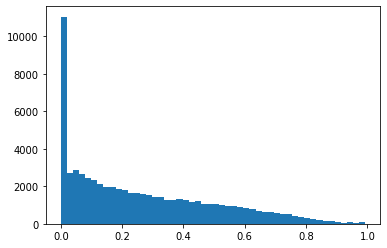

In [9]:
hh = plt.hist(clusterer.outlier_scores_, bins=50)

As you can see, there are very few outlying points beyond _0.8_. The proportion of points with outlier scores below _0.8_ is quite large indeed:

In [10]:
scores = clusterer.outlier_scores_
print("Below 0.8 you can find {:.2f}% of the cluster points.".format(100.0 * scores[scores < 0.8].shape[0] / scores.shape[0]))

Below 0.8 you can find 97.85% of the cluster points.


Let's have another look at this distribution. In the following plot, the _x_ axis reepresents the outlier score and the _y_ axis represents the proportion of cluster points with up to the given outlier score.

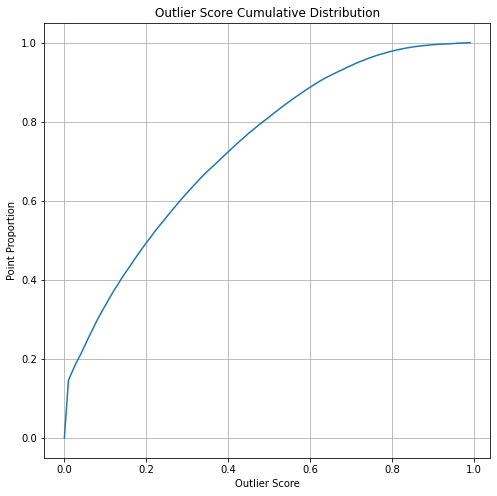

In [11]:
plt.rcParams['figure.figsize'] = [8, 8]
score_shape = [scores[scores < x].shape[0] / scores.shape[0] for x in np.arange(0.0, 1.0, 0.01)]
plt.plot(np.arange(0.0, 1.0, 0.01), score_shape)
plt.xlabel("Outlier Score")
plt.ylabel("Point Proportion")
plt.title("Outlier Score Cumulative Distribution")
plt.grid(True)

In [12]:
pd.Series(scores).quantile(0.95)

0.7169850540474147

Let's see some visuals!

## Interactive Cluster Exploration

Here you can explore all the generated clusters through the interactive widget below. The `show_cluster_map` displays a cluster map with all the points colored according to their outlier score. The more a point color shifts to red, the higher its outlier score. For your convenience, each point has a tooltip with its score.

In [13]:
def show_cluster_map(cluster_id):
    blue = Color("blue")
    red = Color("red")
    color_range = list(blue.range_to(red, 10))
    
    map = folium.Map(prefer_canvas=True, tiles='CartoDB positron')
    
    clusters = clusterer.labels_
    outlier_scores = clusterer.outlier_scores_
    
    points = locations[clusters == cluster_id]
    scores = outlier_scores[clusters == cluster_id]
    
    for i in range(points.shape[0]):
        point = points[i]
        color = color_range[int(scores[i] * 10)]
        CircleMarker(point, radius=1, color=color.hex, tooltip="{:.2f}".format(scores[i])).add_to(map)
        
    min_lat, max_lat = points[:, 0].min(), points[:, 0].max()
    min_lon, max_lon = points[:, 1].min(), points[:, 1].max()
    map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return map

In [14]:
ii = interact(show_cluster_map, cluster_id=widgets.IntSlider(min=0, max=clusterer.labels_.max(), step=1, value=0))

interactive(children=(IntSlider(value=0, description='cluster_id', max=289), Output()), _dom_classes=('widget-…

### Outlier Filtering

We now must make good on our promise and filter the offending outliers. We do this by marking as noise all the points with an outlier score above _0.8_.

In [ ]:
filtered_clusters = np.copy(clusterer.labels_)
filtered_clusters[scores >= 0.8] = -1

## Serialize to the Database

For the sake of future convenience, we will now create and fill in a table whith all the cluster points. This table will make our life much easier in the future, when handling clusters, their locations and shapes.

We start by making sure that the table exists and is empty.

In [ ]:
if not db.table_exists("cluster_point"):
    sql = """
    CREATE TABLE cluster_point (
        pt_id           INTEGER PRIMARY KEY ASC,
        cluster_id      INT NOT NULL,
        latitude        FLOAT NOT NULL,
        longitude       FLOAT NOT NULL,
        h3              TEXT
    )
    """
    db.execute_sql(sql)
    db.execute_sql("CREATE INDEX idx_cluster_point_cluster ON cluster_point (cluster_id)")
else:
    db.execute_sql("DELETE FROM cluster_point")

Now, we can insert the locations for each cluster, along with the [H3](https://eng.uber.com/h3/) hexagon codes at [resolution level 12](https://uber.github.io/h3/#/documentation/core-library/resolution-table). In the next notebook, we will display the clusters using the outline of the collated shapes of all cluster hexagons.

To prepare the insert statement, we now collect all the input data into a list:

In [ ]:
h3_level = 12
cluster_points = []
for i in tqdm(range(filtered_clusters.shape[0])):
    if filtered_clusters[i] >= 0:
        pt = (int(filtered_clusters[i]), locations[i, 0], locations[i, 1], h3.geo_to_h3(locations[i, 0], locations[i, 1], h3_level))
        cluster_points.append(pt)

We can now insert the cluster points into the table.

In [ ]:
db.insert_cluster_points(cluster_points)

The DataFrame can also be updated with the cluster identifiers like so:

In [ ]:
n = filtered_clusters.shape[0] // 2
df_pt['cluster_ini'] = filtered_clusters[:n]
df_pt['cluster_end'] = filtered_clusters[n:]

This is how the DataFrame looks like after cluster identifier assignment. Note that the constant `-1` means that the point was not assigned to any cluster, and was considered as noise instead. We will exclude these from the future trajectory analyses.

In [ ]:
df_pt.head()

## Modifying the `move` Table

Now that we have the clusters identified, we can assign them back to the `move` table. Unfortunately, this table has no columns where to store the clusters identifiers, so we must first handle that. For convenience, we also create an extra index on the new columns for more convenient search on them.

**Notes**: 
- The function `table_has_column` tests whether a given table has a named column. Here we only test against one column as it is enough.
- Depending on the time you use this code, the database may already have been created with these columns and indexes. If that is the case, the code below does nothing.

In [ ]:
if not db.table_has_column('move', 'cluster_ini'):
    db.execute_sql("alter table move add cluster_ini INT not null default -1")
    db.execute_sql("alter table move add cluster_end INT not null default -1")
    db.execute_sql("create index idx_move_clusters on move (cluster_ini, cluster_end)")

We are now ready to update the `move` table using the recently calculated cluster identifiers. To do so, we use the data stored in the DataFrame to feed an update query. Note that we retrieve the data as a list of tuples with the eaxct order for consumption in the query.

In [ ]:
clids = list(df_pt[['cluster_ini', 'cluster_end', 'move_id']].itertuples(index=False))

In [ ]:
db.update_move_clusters(clids)

We have now associated each move with a pair of endpoint clusters, and this allows us to perform more powerful analyses to the data, such as determine how many trips occur between two general endpoints, how many different trajectories there are and what vehicles have used them and at what time, consuming how much fuel or energy.

Now, we turn to the issue of generating a geo-fence for the clusters so they can be easily displayed on a map.